In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io

import matplotlib as mpl
%matplotlib inline

mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, rgb2hex
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'


from cellpose import utils
from skimage.io import imread
import scipy
from skimage.morphology import binary_erosion, binary_dilation, medial_axis, disk, medial_axis,remove_small_holes,remove_small_objects
# import skfmm
import cv2

import fastremap #important for relabeling! Could move just to color function perhaps, but idk of other parts of cellpose require sequential lebel matrices; probably worth it


from cellpose import models, io, dynamics, plot, transforms, omnipose
from cellpose.omnipose.utils import rescale
def laplacian(I):
    Iy,Ix = np.gradient(I)
    mu = transforms.normalize_field(np.stack((Iy,Ix)))
    Iyy,Iyx = np.gradient(mu[0])
    Ixy,Ixx = np.gradient(mu[1])
    return Ixx+Iyy

def divergence(mu):
    mask = np.sqrt(np.sum(dP**2,axis=0))
    Ly,Lx = mask.shape
    Y, X = np.nonzero(mask)
    pad = 1
    Tx = np.zeros((Ly+2*pad)*(Lx+2*pad), np.float64)
    Tx[Y*Lx+X] = np.reshape(dP[1].copy(),Ly*Lx)[Y*Lx+X]
    Ty = np.zeros((Ly+2*pad)*(Lx+2*pad), np.float64)
    Ty[Y*Lx+X] = np.reshape(dP[0].copy(),Ly*Lx)[Y*Lx+X]

    div = np.zeros(Ly*Lx, np.float64)
    div[Y*Lx+X]=(Ty[(Y+2)*Lx+X]+8*Ty[(Y+1)*Lx+X]-8*Ty[(Y-1)*Lx+X]-Ty[(Y-2)*Lx+X]+
                 Tx[Y*Lx+X+2]+8*Tx[Y*Lx+X+1]-8*Tx[Y*Lx+X-1]-Tx[Y*Lx+X-2])
    div.shape = (Ly,Lx)
    return div
    
def derivative(T,masks):
    Ly,Lx = T.shape
    mu = np.zeros((2,Ly,Lx))
    pad = 1
    slices = scipy.ndimage.find_objects(masks) 
    for i,si in enumerate(slices):
        if si is not None:
            sr,sc = si
            mask = np.pad((masks[sr, sc] == i+1),pad)
            ly, lx = sr.stop - sr.start + 2*pad, sc.stop - sc.start + 2*pad
            y, x = np.nonzero(mask) 
            ly = np.int32(ly)
            lx = np.int32(lx)
            y = y.astype(np.int32)  #no need to shift, as array already padded
            x = x.astype(np.int32)    

            T_ = np.zeros((ly+2*pad)*(lx+2*pad), np.float64)
            T_[y*lx+x] = T[sr.start+y-pad, sc.start+x-pad]
            dy = (T_[(y+1)*lx + x] - T_[(y-1)*lx + x]) / 2
            dx = (T_[y*lx + x+1] - T_[y*lx + x-1]) / 2
            mu[:, sr.start+y-pad, sc.start+x-pad] = np.stack((dy,dx))
    return mu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loaded array is of type: <class 'numpy.ndarray'>
Loaded array has shape: (194, 136)
Loaded values are of type: uint16


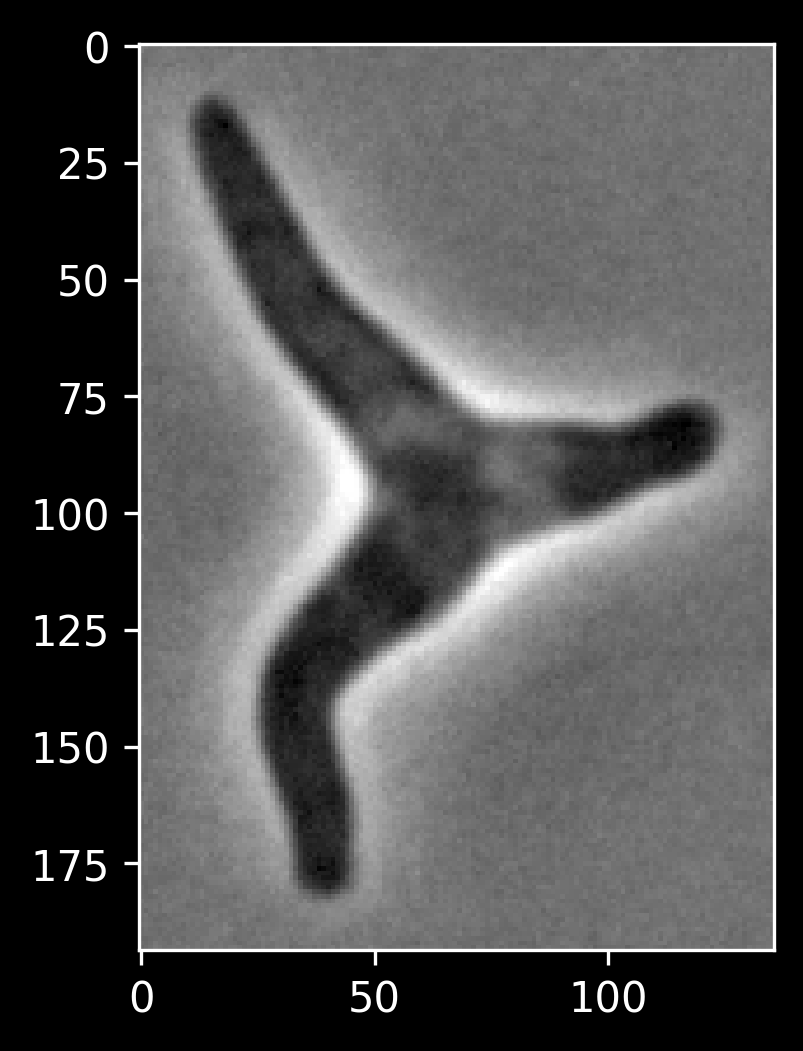

In [42]:
pos = 'cell_4243'
# pos = 'cell_4030'
# pos = 'hpaz2xy1_10'
# pos = 'hpaz2xy1_21'
# basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure 3/'+pos

basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure 4/'+pos

maskdir = basedir + '_mask.png'

masks = imread(maskdir).astype(np.uint16)
if len(masks.shape)>2:
    masks, remap = fastremap.renumber(masks[:,:,1])
    
bg = 0.5
p = omnipose.utils.normalize99(imread(basedir + '_phase.png'))
phase = p**(np.log(bg)/np.log(np.mean(p[binary_erosion(masks==0)])))


print("Loaded array is of type:", type(masks))
print("Loaded array has shape:", masks.shape)
print("Loaded values are of type:", masks.dtype)
plt.imshow(phase)

In [43]:
masks_rgb = np.stack([masks]*3,axis=-1)
pic = 1-rescale(masks_rgb)
io.imsave(basedir + '_masks_rbg.png',(pic*(2**8-1)).astype(np.uint8))

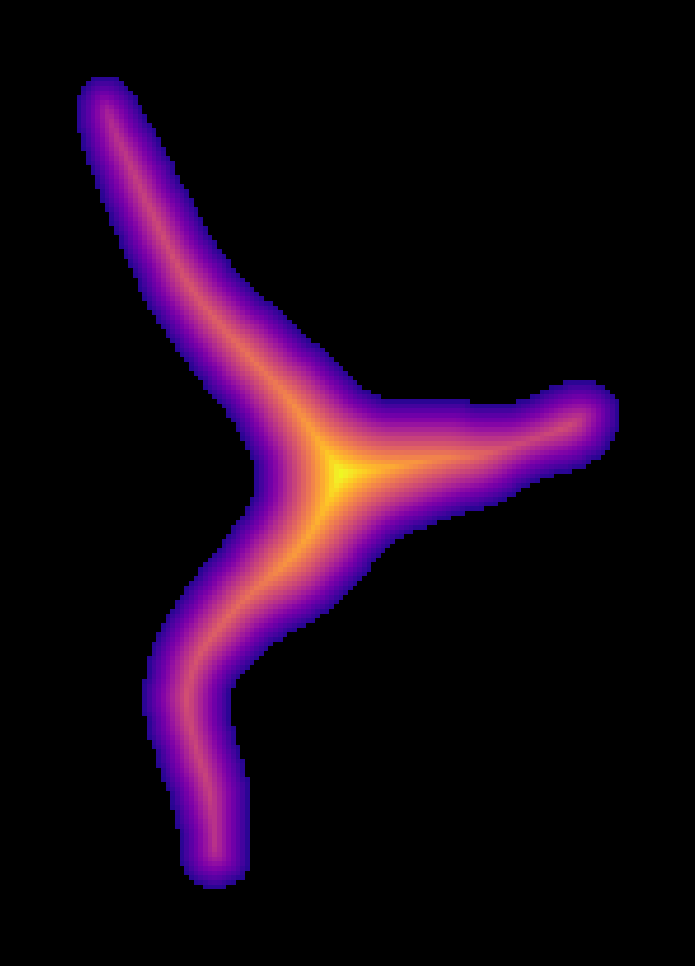

In [44]:
omni = 1
fmm = 0
if omni:
    if fmm:
        suffix = '_fmm'
    else:
        suffix = ''
else:
    suffix = '_OG'

    
if not fmm:
    labels,dists,heat,flows = dynamics.masks_to_flows(masks,use_gpu=True,omni=omni)
    dP = np.stack([flows[0],flows[1]])
else:
    heat = edt.edt(masks)
    dP = derivative(heat,masks)
    dP = transforms.normalize_field(dP)

cmap = mpl.cm.get_cmap('plasma')
pic = cmap(rescale(heat))
pic[:,:,-1] = masks>0
plt.imshow(pic)
plt.axis('off')
plt.show()
skimage.io.imsave(basedir + '_8bit_heat' + suffix + '.png',((pic)*255).astype(np.uint8))

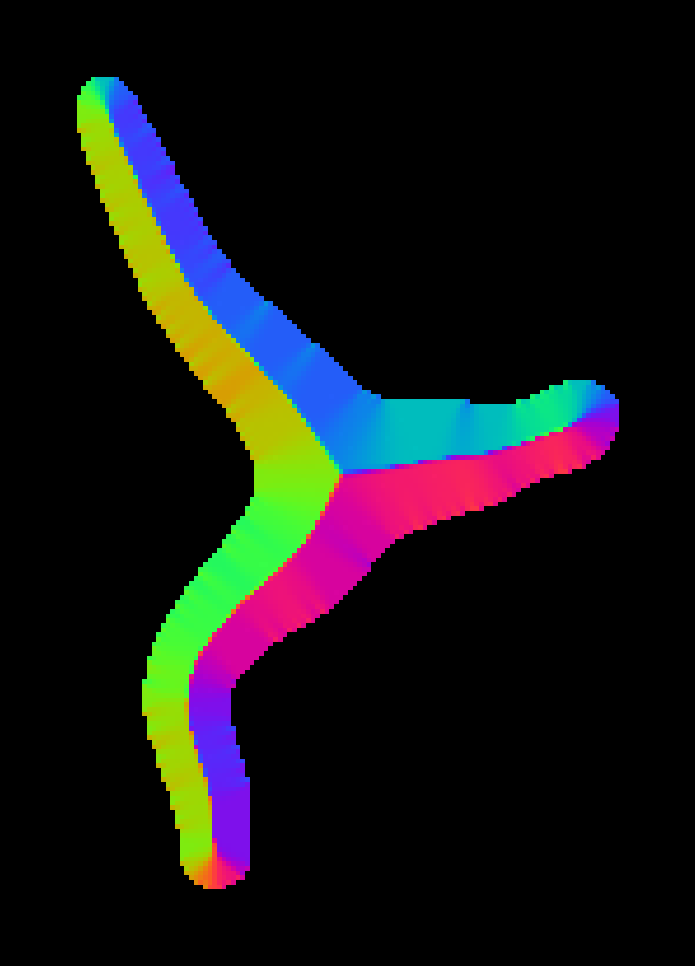

In [45]:
gt_flow = plot.dx_to_circ(dP,transparency=True)
pic = gt_flow
plt.imshow(pic)
plt.axis('off')
skimage.io.imsave(basedir + '_GT_flow'+suffix+'.png',(pic*(2**8-1)).astype(np.uint8))

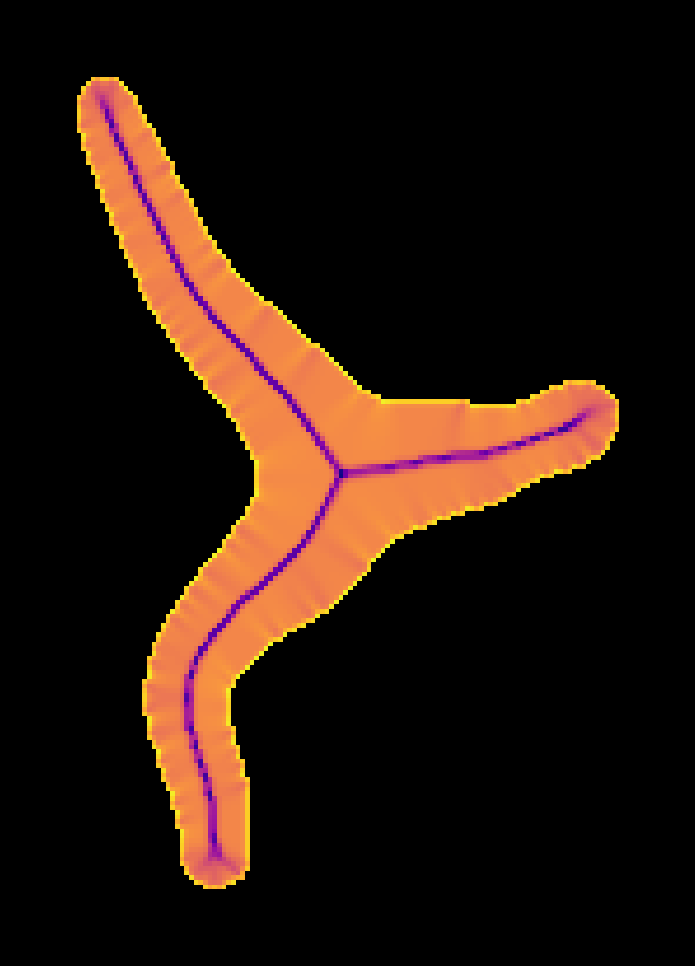

In [46]:
# plt.imshow(np.sqrt(np.sum(dP**2,axis=0)))
div = rescale(divergence(dP))
# pic = np.stack([div]*3,axis=-1)
pic = cmap(div)
# pic[:,:,-1] = rescale(heat**a)
pic[:,:,-1] = masks>0
plt.imshow(pic)
plt.axis('off')
skimage.io.imsave(basedir + '_GT_divergence'+suffix+'.png',(pic*(2**8-1)).astype(np.uint8))

In [47]:
omni=1
if omni:
    if fmm:
        suffix = '_fmm'
    else:
        suffix = ''
else:
    suffix = '_OG'

import edt
# inds = np.array(np.nonzero(np.logical_or(masks>0,np.abs(dP[0])>1e-3))).astype(np.int32).T
dists = edt.edt(masks)
dists[dists==0]=-5
inds = np.array(np.nonzero(masks)).astype(np.int32).T
print(inds.shape)
masks_pred, p, tr = dynamics.compute_masks(dP,dists,inds=inds,calc_trace=True,use_gpu=0,
                                           omni=omni,niter=200,interp=1,mask_threshold=-1,verbose=True,
                                          flow_threshold = 0.0,min_size=0)
# masks, flows, styles = model[0].eval(phase_list,channels=[0,0],dist_threshold=-1,flow_threshold=0,omni=0, calc_trace=True,min_size=0)

(5238, 2)
2021-11-11 19:48:39,682 [INFO] mask_threshold is -1.000000
2021-11-11 19:48:39,682 [INFO] Using hysteresis threshold.
2021-11-11 19:48:39,721 [INFO] Mean diameter is 36.668326


True

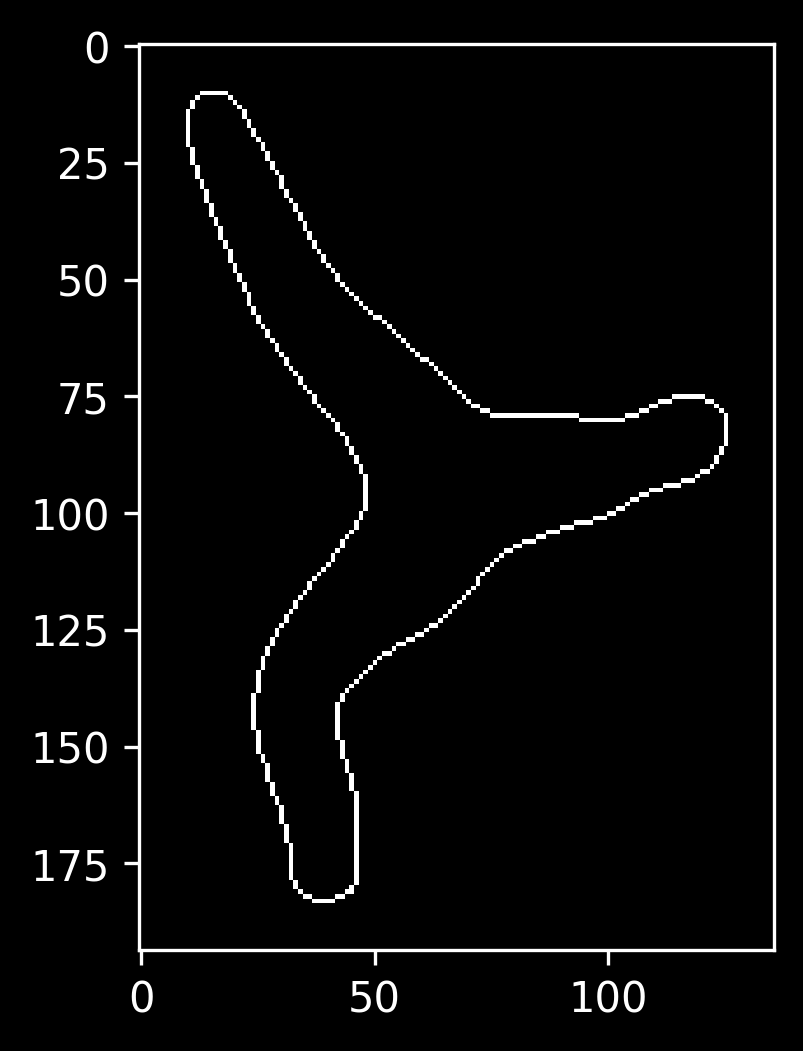

In [48]:
dists_pred = edt.edt(masks_pred)
bd = np.logical_or(dists==1,dists_pred==1)
# bd = dists_pred==1
plt.imshow(bd)
np.any(masks_pred)

(2, 5238, 200) 5238


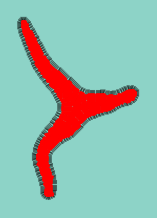

In [49]:
from matplotlib import rc

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 72
%matplotlib inline

A = 1.5
px = A/plt.rcParams['figure.dpi']  # pixel in inches

print(tr.shape,np.count_nonzero(masks_pred))
Y,X = np.nonzero(bd) #boundary only
# select_inds = np.flatnonzero(masks)
a = .5
match = [np.any(np.logical_and((X-tr[1,i,0])**2<a,(Y-tr[0,i,0])**2<a)) for i in range(tr.shape[1])]
select_inds = np.argwhere(match).flatten()
lx = masks_pred.shape[1]
ly = masks_pred.shape[0]
# (tr[1,:,0]+1)*lx/2,X
# fig,ax = plt.subplots()
fig,ax = plt.subplots(figsize=(ly*px,lx*px))
ax.set_aspect('equal')
ax.axis('off')
# ax.imshow()
ax.set_position([0, 0, 1, 1])
# ax.imshow(np.zeros((ly,lx,4)))
# plt.imshow(gt_flow)
# for i in range(tr.shape[1]):
for i in select_inds:
#     xs = (tr[1,i,:]+1)*lx/2
#     ys = (tr[0,i,:]+1)*ly/2
    xs = tr[1,i,:]
    ys = tr[0,i,:]
    ax.plot(xs,ys,c=[0,0,0,.5],solid_capstyle='round',linewidth=np.sqrt(A))

for i in range(tr.shape[1]):
    ax.plot(tr[1,i,-1],tr[0,i,-1],'r.',markersize=px*lx)

ax.set_xlim([0,lx])
ax.set_ylim([ly,0])
ax.patch.set_alpha(0.)
fig.patch.set_facecolor(None)
plt.show()
fig.savefig(basedir + '_perim_flows' + suffix + '.svg',bbox_inches=0,transparent=True,pad_inches=0)
fig.savefig(basedir + '_perim_flows' + suffix + '.pdf',bbox_inches='tight',transparent=True,pad_inches=0)

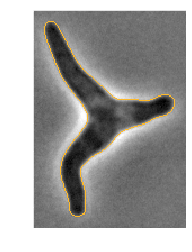

In [50]:
cmap = mpl.cm.get_cmap('plasma')
outline = plot.outline_view(rescale(phase),masks_pred,color=cmap(.85)[:3])#,mode='thick')
plt.imshow(outline)
skimage.io.imsave(basedir + '_outlines'+suffix+'.png',(outline*(2**8-1)).astype(np.uint8))
# np.any(masks_pred)

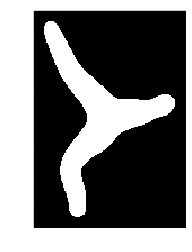

In [51]:
plt.imshow(masks_pred)
# plt.imshow(dists)
# plt.axis('off')
# plt.show()
# io.imsave(basedir + '_dists' + '.png',(rescale(dists)*255).astype(np.uint8))

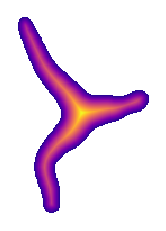

In [52]:
cmap = mpl.cm.get_cmap('plasma')
if omni:
    a = 1
else:
    a = 1/6
outlines = utils.masks_to_outlines(masks)
outY, outX = np.nonzero(outlines)
pic = np.stack([rescale(heat)]*3,axis=-1)**a
pic[outY,outX] = np.array([1,0,0])
if not omni:
    y, x = np.nonzero(masks)
    ymed = int(round(np.mean(y)))
    xmed = int(round(np.mean(x)))
    pic[ymed,xmed]=np.array([1,1,0])
    imin = np.argmin((x-xmed)**2 + (y-ymed)**2) 
    xmed = np.array([x[imin]],np.int32)
    ymed = np.array([y[imin]],np.int32)
    pic[ymed,xmed]=np.array([0,1,1])

pic = cmap(rescale(heat)**a)
# pic[:,:,-1] = rescale(heat**a)
pic[:,:,-1] = masks>0
plt.imshow(pic)
plt.axis('off')
plt.show()

skimage.io.imsave(basedir + '_8bit_heat_' + suffix + '.png',((pic)*255).astype(np.uint8))

In [53]:
omni

1

In [56]:
# omni = True
ext = '.tif'

if omni:
    suffix = '_OM'
else:
    suffix = '_OP'
    
flows = imread(basedir + '_flows' + suffix + ext)
cellprob = imread(basedir + '_cellprob' + suffix + ext)
pic = plot.dx_to_circ([flows[0,:,:],flows[1,:,:]])

print(flows.shape)
plt.figure(figsize=(10,10))
# plt.imshow(plot.dx_to_circ([flows[:,:,1],flows[:,:,2]]))
plt.imshow(pic)
plt.axis('off')
plt.show()

# dP = flows[0,-2:,:,:]

io.imsave(basedir + '_8bit_flow' + suffix + '.png',(pic*(2**8-1)).astype(np.uint8))

FileNotFoundError: [Errno 2] No such file or directory: '/home/kcutler/DataDrive/omnipose_paper/Figure 4/cell_4243_flows.tif'